In [1]:
import warnings
warnings.filterwarnings('ignore')
import FateAxis.tool.main_function as fa
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
import FateAxis.tool.extractor as ext
import cospar as cs
import scipy.stats as stats
import cospar as cs
from scipy.stats import rankdata
import FateAxis.tool.preprocessor as pp
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [2]:
adata = sc.read_h5ad('/data/jiangjunyao/AEGAS_data/fate/CellTag2018.h5ad')
adata.obs['time_info'] = 'late'
adata.obs.loc[adata.obs['celltype'] == 'Others', 'time_info'] = 'early'

Clones without any cells are removed.
Time points with clonal info: ['early' 'late']
Step I: Generate pseudo clones where each cell has a unique barcode-----
Step II: Perform joint optimization-----
--------Infer transition map between initial time points and the later time one-------
--------Current initial time point: early--------
Step 0: Pre-processing and sub-sampling cells-------
--> Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.005706310272216797
Smooth round: 2
--> Time elapsed: 0.035773515701293945
Smooth round: 3
--> Time elapsed: 0.14206552505493164
--> Orignal sparsity=0.28825255707518516, Thresholding
--> Final sparsity=0.19126771083495403
similarity matrix truncated (Smooth round=3):  0.12440299987792969
Smooth round: 4
--> Time elapsed: 0.24095678329467773
--> Orignal sparsity=0.4599572154491567, Thresholding
--> Final sparsity=0.2808240940611373
similarity matrix truncated (Smooth round=4):  0.0841670036315918
Smooth round: 5
-->

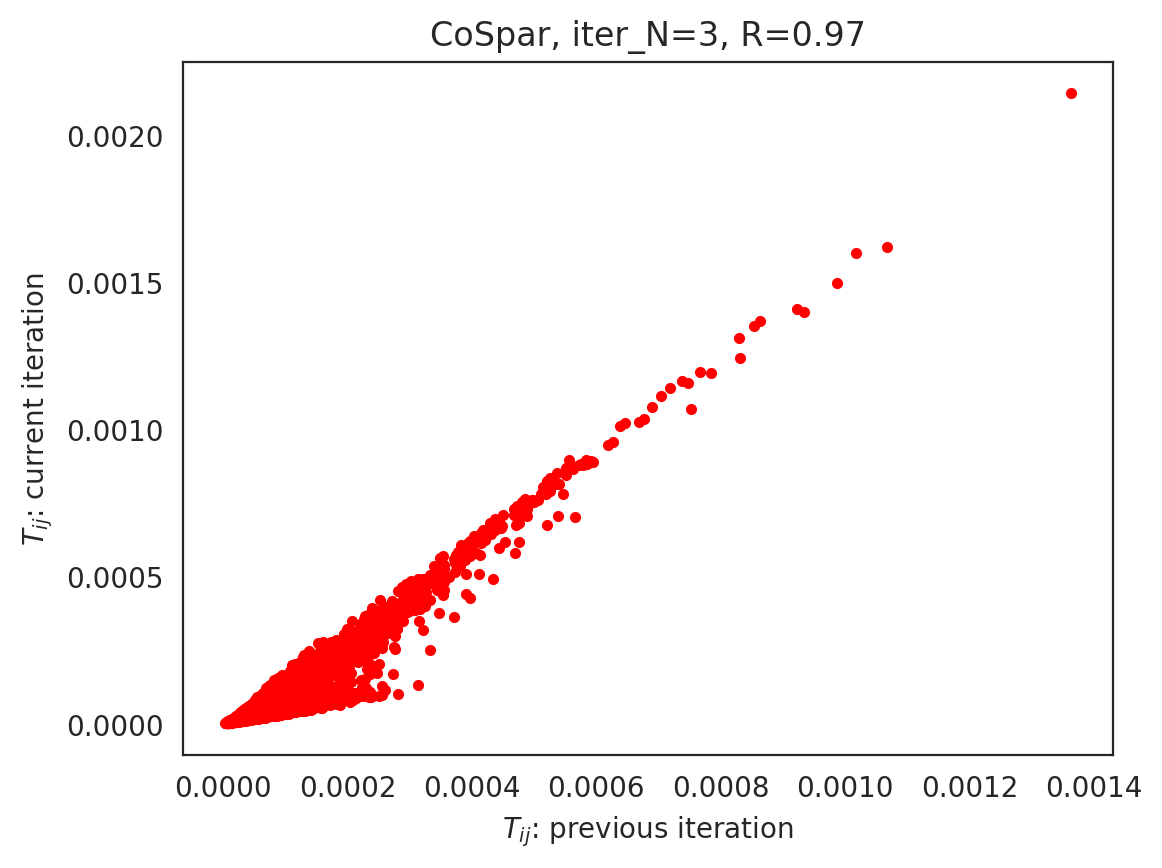

--> No need for Final Smooth (i.e., clonally-labeled states are the final state space for Tmap)
--> ----Intraclone transition map----
--> Clone normalization
--> Relative time point pair index: 0
--> Clone id: 0


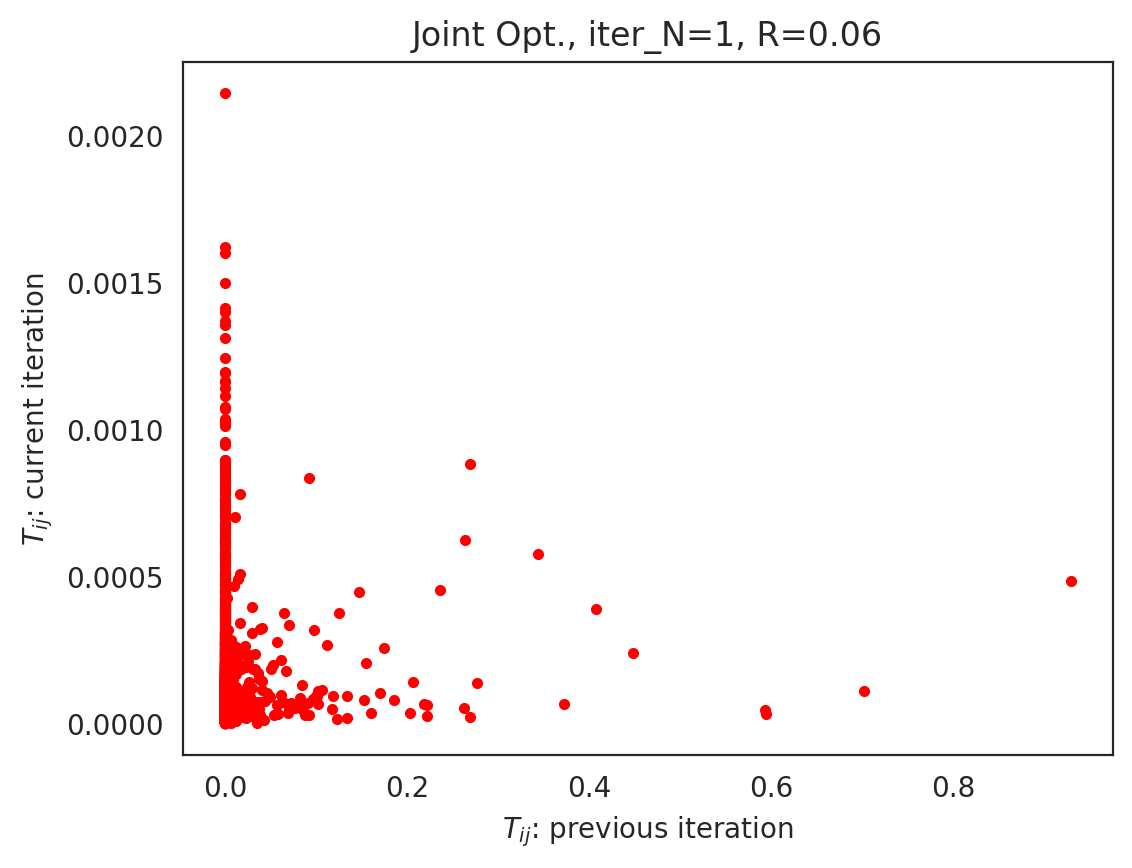

Finishing Joint Optimization, used time 3.2296042442321777
-----------Total used time: 35.67013955116272 s ------------


In [3]:
adata.obs['state_info'] = adata.obs['celltype']
adata = cs.pp.initialize_adata_object(adata)
adata_2 = cs.tmap.infer_Tmap_from_state_info_alone(
    adata,
    initial_time_points=["early"],
    later_time_point="late",
    initialize_method="OT",
    OT_cost="GED",
    smooth_array=[20, 15, 10],
    max_iter_N=[1, 3],
    sparsity_threshold=0.2,
    use_full_Smatrix=True,compute_new=True
)

In [4]:
cs.tl.progenitor(adata_2,selected_fates=['Failed', 'Reprogrammed'])
adata.obs['pred'] = np.nan
condition = adata_2.obs['progenitor_transition_map_Failed'] == 1

adata_2.obs.loc[condition, 'pred'] = 'Failed'
condition = adata_2.obs['progenitor_transition_map_Reprogrammed'] == 1

adata_2.obs.loc[condition, 'pred'] = 'Reprogrammed'

Results saved at adata.obs['fate_map_transition_map_Failed']
Results saved at adata.obs['fate_map_transition_map_Reprogrammed']
Results saved at adata.obs['fate_bias_transition_map_Failed*Reprogrammed']
Results saved at adata.obs[f'progenitor_transition_map_Failed'] and adata.obs[f'diff_trajectory_transition_map_Failed']
Results saved at adata.obs[f'progenitor_transition_map_Reprogrammed'] and adata.obs[f'diff_trajectory_transition_map_Reprogrammed']


In [6]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
adata_final = adata_2[adata_2.obs.celltype=='Others']
y_pred = adata_final.obs['pred']
y_true = adata_final.obs['lineage']

# 计算准确性

accuracy = accuracy_score(y_true, y_pred)

# 计算召回率

recall = recall_score(y_true, y_pred, average='macro')  # 根据需要选择合适的average参数

# 计算F1分数

f1 = f1_score(y_true, y_pred, average='macro')  # 根据需要选择合适的average参数

# 输出结果

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.35714285714285715
Recall: 0.15889830508474576
F1 Score: 0.2127659574468085


... storing 'time_info' as categorical
... storing 'pred' as categorical


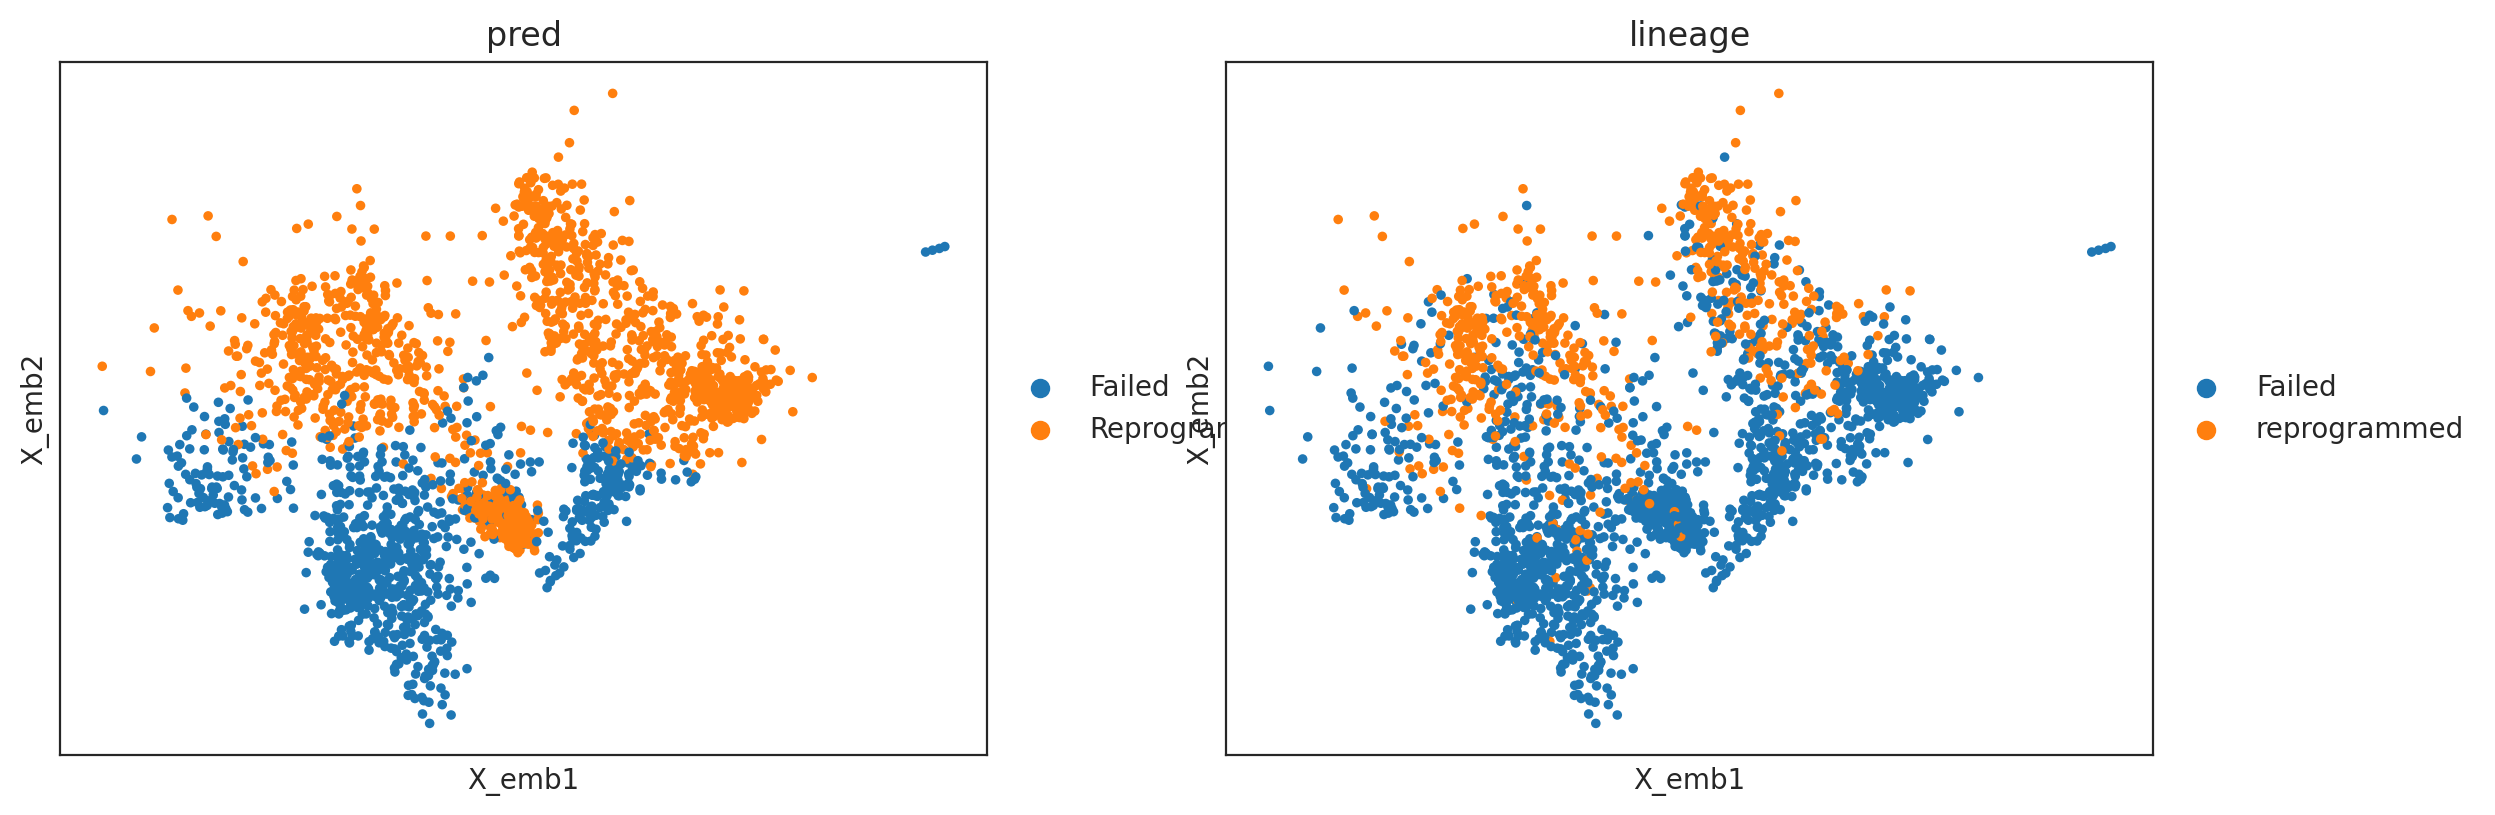

In [7]:
sc.pl.embedding(adata_final,color=['pred','lineage'],basis='X_emb')

In [8]:
adata_2.write('/data/jiangjunyao/AEGAS_analysis/pred_result/cospar_celltagy.h5ad')
adata_2.obs.to_csv('/data/jiangjunyao/AEGAS_analysis/pred_result/cospar_celltag_obs.csv')

... storing 'time_info' as categorical
... storing 'pred' as categorical
